In [2]:
#imports 
import pandas as pd
from operator import itemgetter 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
import matplotlib.ticker as ticker


In [3]:
# lendo e declarando nomes as colunas 
data = pd.read_csv('https://www.bcb.gov.br/adm/mecir/dadosabertos/Falsificacao_DadosAbertos.csv',
                   sep=';',names=['ano','estado','familia','valor_cedula','qtd_apreendida'], decimal='.')

In [4]:
# criando o DataFrame --- não sei pq nao formatou qtd_apreendida 
df = pd.DataFrame(data)
df.qtd_apreendida = df.qtd_apreendida.str.replace(',00','')
df.qtd_apreendida = df.qtd_apreendida.str.replace('.','').astype('int')

df.valor_cedula = df.valor_cedula.astype('int')
print(df.head())

    ano            estado                familia  valor_cedula  qtd_apreendida
0  1995            PARANÁ  Cédulas - 1a. família            50             237
1  1995    RIO DE JANEIRO  Cédulas - 1a. família            50               3
2  1995    RIO DE JANEIRO  Cédulas - 1a. família           100               1
3  1995         SÃO PAULO  Cédulas - 1a. família           100               1
4  1996  DISTRITO FEDERAL  Cédulas - 1a. família            50               1


In [5]:
print(df.head())

    ano            estado                familia  valor_cedula  qtd_apreendida
0  1995            PARANÁ  Cédulas - 1a. família            50             237
1  1995    RIO DE JANEIRO  Cédulas - 1a. família            50               3
2  1995    RIO DE JANEIRO  Cédulas - 1a. família           100               1
3  1995         SÃO PAULO  Cédulas - 1a. família           100               1
4  1996  DISTRITO FEDERAL  Cédulas - 1a. família            50               1


In [6]:
# ordena pelo valor e corta dicionario(opcional)
def dict_sort(dicV, cort = ''):
    if(cort==''):
        cort = len(dicV)
    sort_dic = sorted(dicV.items(), key = itemgetter(1), reverse = True)[:cort]
    dicN = {}
    for x in sort_dic :
        dicN[x[0]] = x[1]
    return dicN
        
#função para formatar milhões de reais
def milhoes(x, pos):
    'The two args are the value and tick position'
    return 'R$%1.1fM' % (x * 1e-6)

#função para formatar milhares
def mil(x,pos):
    return '%1.0f mil' % (x* 1e-3)



# função para analisar e gerar grafico dos 5 estados (default) que mais falsificam notas
# nos ultimos 5 anos (dafault) ordenado pela quantidade de notas(default) ou pelo montante :) 
def fazGraficoDosEstadosComMaisFalsificacao(df,qtd_ano=5,n_estados=5,agrupar='quantidade'):
    
    anos = [str(value) for value in range((2019-qtd_ano),2019+1)]    
    dado_filtrados_ano = df.loc[df.ano.isin(anos)]
    dado_filtrados_ano = dado_filtrados_ano.groupby(by=['estado'])
    dic = {}
    for grupo in dado_filtrados_ano:
        if(agrupar == 'quantidade'):
            dic[grupo[0]] = grupo[1].qtd_apreendida.sum()
        elif(agrupar== 'montante'):
            soma = 0
            for linha in grupo[1].values:
                soma += linha[3] * linha[4]                
            dic[grupo[0]] = soma
            
                
    dic = dict_sort(dic,n_estados)    
        
    dados = pd.DataFrame()
    dados['Estados'] = list(dic.keys())
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    if(agrupar == 'quantidade'):
        formatter = ticker.FuncFormatter(mil)
        dados['Qtd_Cedulas'] = list(dic.values())
        ax = sns.barplot(x='Qtd_Cedulas', y="Estados", data=dados, alpha=0.8)
        ax.set(xlabel='Quantidade de cedulas apreendidas',ylabel='Estados',
               title="Os "+str(n_estados)+" estados onde são apreendidos mais cedulas falsas nos ultimos "+str(qtd_ano)+" anos.")
        ax.xaxis.set_major_formatter(formatter)

    else:
        formatter = ticker.FuncFormatter(milhoes)
        dados['R$'] = list(dic.values())
        ax = sns.barplot(x='R$',y="Estados",data=dados,alpha=0.8)
        ax.set(xlabel='Total em milhões de R$',ylabel='Estados',
               title="Os "+str(n_estados)+" estados com maior montante de dinheiro falso apreendido nos ultimos "+str(qtd_ano)+" anos")
        ax.xaxis.set_major_formatter(formatter)

    plt.savefig('estatistica_falsifificação.png')


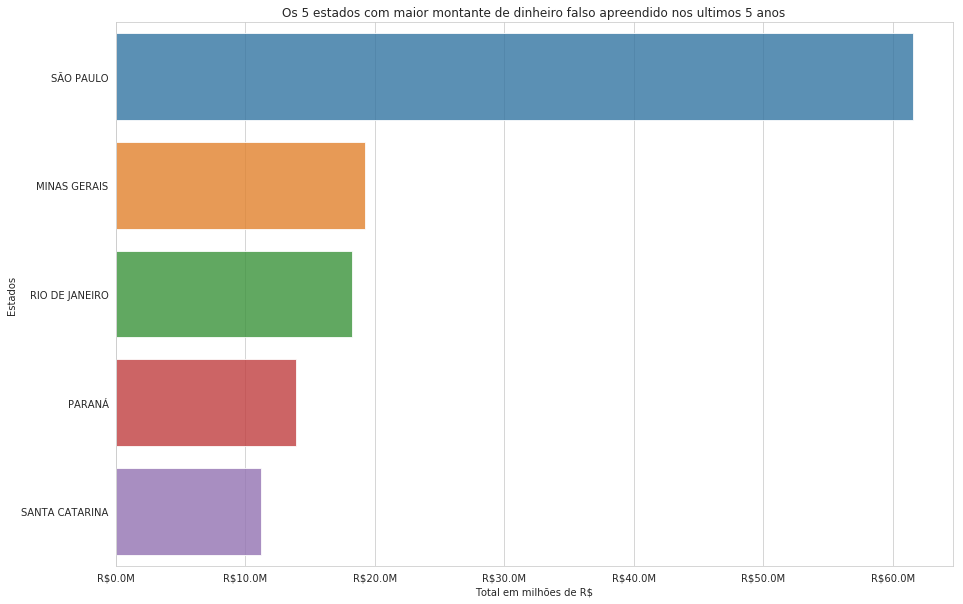

In [7]:
fazGraficoDosEstadosComMaisFalsificacao(df,5,5,'montante')

In [8]:
#faz grafico das notas mais falsificadas nos ultimos 5(default) anos
def modaNotasFalsificadas(df=pd.DataFrame(),qtd_ano=5):
    
    #agrupa por valor da nota e soma o total recolhido
    anos = [str(value) for value in range((2019-qtd_ano),2019+1)]    
    dado_filtrados_ano = df.loc[df.ano.isin(anos)]
    dado_filtrados_ano = dado_filtrados_ano.groupby(by=['valor_cedula'])
    dic = {}
    for x in dado_filtrados_ano:
        dic[x[0]] = x[1].qtd_apreendida.sum()
        
        
    #ordenando dicionario criado 
    dic = dict_sort(dic)
    
    #definido dataFrame
    dados = pd.DataFrame()
    dados['Valor_cedula'] = list(dic.keys())
    dados['Qtd_Cedulas'] = list(dic.values())

    #gerando grafico e editando
    formatter = ticker.FuncFormatter(milhoes)
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 12))
    ax = sns.barplot(x="Valor_cedula", y="Qtd_Cedulas", data=dados)
    
    ##label em cima da bar
    for i, valor in enumerate(dados.Qtd_Cedulas[::-1]):
        ax.text(i, valor, round(valor, 1), horizontalalignment='center', fontsize=12)

    # detalhes como legendas, titulo e formatação do eixo y
    ax.set(xlabel='Nota',ylabel='Total de cedulas',
               title="As notas mais falsificadas nos ultimos "+ str(qtd_ano) +" anos")
    ax.yaxis.set_major_formatter(formatter)

    

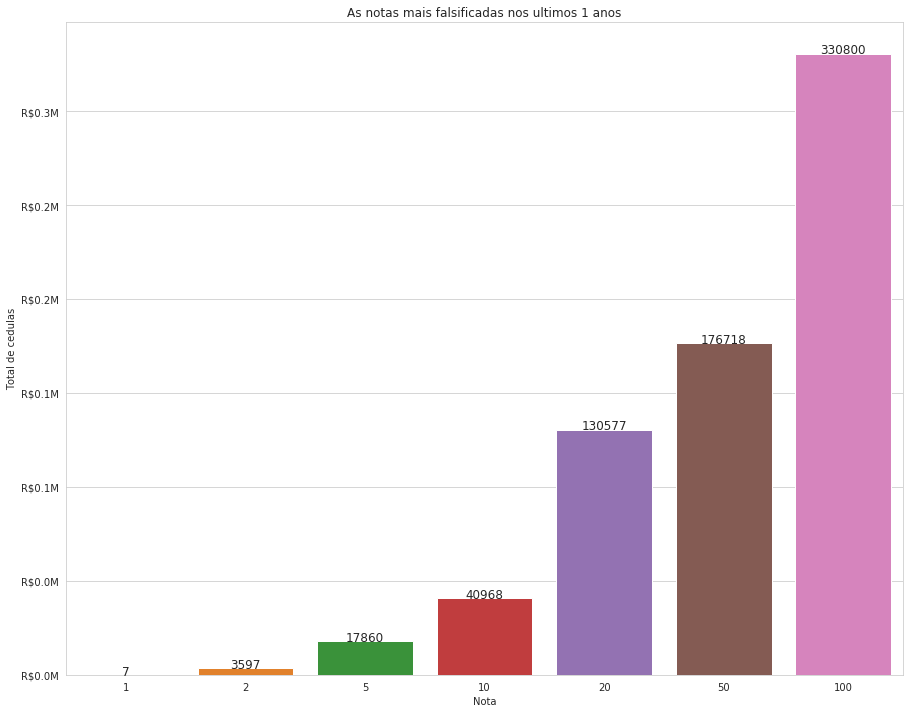

In [9]:
modaNotasFalsificadas(df,1)

In [10]:
def curvaFalsificacaoTotalBrasil(df = pd.DataFrame(),qtd_ano=5,calcularTotal="quantidade"):
    anos = [str(value) for value in range((2019-qtd_ano),2019)]    
    dado_filtrados_ano = df.loc[df.ano.isin(anos)]
    dado_filtrados_ano = dado_filtrados_ano.groupby(by=['ano'])

    dic = {}
    for x in dado_filtrados_ano:
        dic[str(x[0])] = x[1].qtd_apreendida.sum()
    
    
    dados = pd.DataFrame()
    dados['Anos'] = list(dic.keys())
    dados['Qtd_Cedulas'] = list(dic.values())
    
    plt.figure(figsize=(15,9))
    ax =  sns.lineplot(x="Anos", y="Qtd_Cedulas", style=True,
                        markers=True , data=dados, legend=False)

    sns.set_style("whitegrid")
    formatter = ticker.FuncFormatter(milhoes)

    ax.set(xlabel="Anos",ylabel="Total de cedulas",
               title="Falsificação de notas no Brasil nos ultimos "+str(qtd_ano)+" anos")

    ax.yaxis.set_major_formatter(formatter)

    ax.set_ylim(0, dados.Qtd_Cedulas.max() + 100000)
    for i, valor in enumerate(dados.Qtd_Cedulas):
        ax.text(i,valor+10000,valor)

   

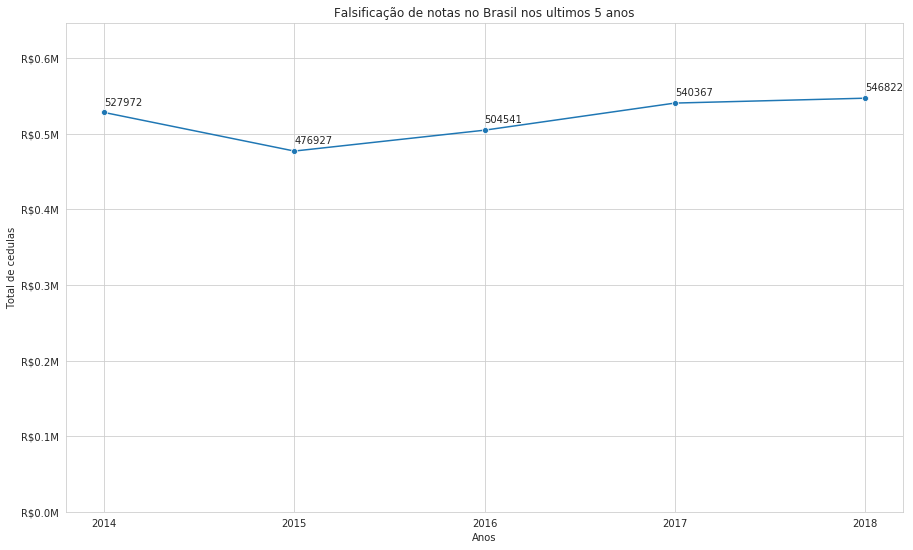

In [11]:
curvaFalsificacaoTotalBrasil(df,5)

In [12]:
# Entre como parametro o dataFrame, qtd anos e um array de estados para realizar as funções 
def curvaPorEStados(df= pd.DataFrame(),qtd_ano=5,estados=['SÃO PAULO','RIO DE JANEIRO']):
    anos = [str(value) for value in range((2019-qtd_ano),2019)]    
    dado_filtrados_ano = df.loc[df.ano.isin(anos)]
    dado_filtrados_ano = dado_filtrados_ano.loc[df['estado'].isin(estados)]
    dado_filtrados_ano = dado_filtrados_ano.groupby(by=['ano'])

    
    
    n_df = pd.DataFrame(columns=['estado','ano','valor'])
    n_df.valor = n_df.valor.astype('int')
    for x in dado_filtrados_ano:
        data_estados = x[1].groupby(by=['estado'])
        for y in data_estados:
            n_df.loc[len(n_df)] = [y[0],str(x[0]),y[1].qtd_apreendida.sum()]  
            df.index = df.index + 1  
            df.sort_index(inplace=True) 
            
    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(x="ano", y="valor", markers=True, style="estado",hue="estado", data=n_df)
    
    formatter = ticker.FuncFormatter(mil)

    ax.set(xlabel="Anos",ylabel="Total de cedulas",
               title="Falsificação de notas no Brasil nos ultimos "+str(qtd_ano)+" anos")

    ax.yaxis.set_major_formatter(formatter)

    ax.set_ylim(0, n_df.valor.max() + 100000)

   

   

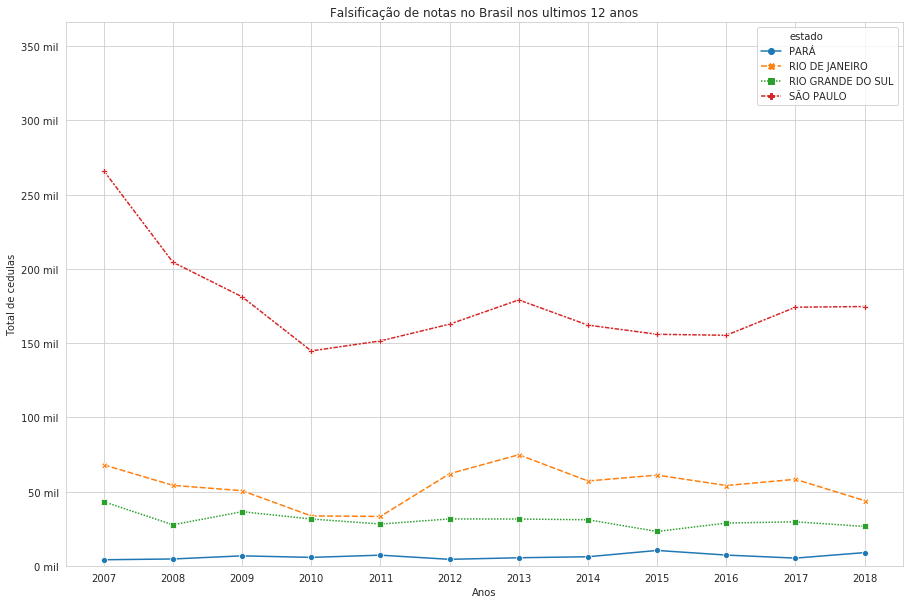

In [13]:
curvaPorEStados(df,12,['SÃO PAULO','RIO DE JANEIRO','PARÁ','RIO GRANDE DO SUL'])